# 1.21d: Dead Token Cloud Geometry

**Goal:** Characterize the bulk statistical properties of the dead token cloud over time.

## The Question

From 1.21c, we know individual dead tokens diverge by ~0.3 units between Flannel 1 and Flannel 2, but the divergence is **very uniform** (all tokens ~0.3, minimal variation).

This raises a question: **Do the two dead token clouds have the same bulk geometry?**

If yes → tokens are at different *angular* positions but same *radial* distribution (like two rotated copies of the same shell)

If no → the clouds have fundamentally different shapes, sizes, or centers

## The Dead Token Universe

We initialize with **N(0, 0.02)** at t=0. Then training happens.

Track these bulk properties over time:

1. **Centroid position:** $\mathbf{c}(t) = \frac{1}{N}\sum_{i \in \text{dead}} \mathbf{W}_i(t)$
2. **Centroid norm:** $\|\mathbf{c}(t)\|_2$ (how far the cloud center drifts from origin)
3. **Cloud radius (from centroid):** $r_{\text{cloud}}(t) = \frac{1}{N}\sum_{i \in \text{dead}} \|\mathbf{W}_i(t) - \mathbf{c}(t)\|_2$
4. **Mean distance from origin:** $r_{\text{origin}}(t) = \frac{1}{N}\sum_{i \in \text{dead}} \|\mathbf{W}_i(t)\|_2$
5. **Standard deviation (per dimension):** $\sigma(t) = \text{std}(W_{\text{dead}}(t))$ (spread along each axis)

Compare Flannel 1 vs Flannel 2 for each metric.

## Parameters

In [1]:
# Data paths
FLANNEL_1_PATH = '../tensors/Flannel/1.20a_flannel_1.safetensors'
FLANNEL_2_PATH = '../tensors/Flannel/1.20b_flannel_2.safetensors'
TOKEN_MASKS_PATH = '../tensors/Flannel/live_dead_tokens.safetensors'

# Visualization
PLOT_DPI = 150
LINEWIDTH = 2
COLOR_F1 = 'steelblue'
COLOR_F2 = 'darkorange'

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading data...\n")

# Flannel 1
data_1 = load_file(FLANNEL_1_PATH)
W_1 = data_1['embeddings'].to(torch.float32).to(device)

# Flannel 2
data_2 = load_file(FLANNEL_2_PATH)
W_2 = data_2['embeddings_W'].to(torch.float32).to(device)

# Token masks
masks = load_file(TOKEN_MASKS_PATH)
dead_mask = masks['dead_mask'].to(device)

n_steps, vocab_size, hidden_dim = W_1.shape
n_dead = dead_mask.sum().item()

print(f"✓ Data loaded")
print(f"  Shape: {W_1.shape}")
print(f"  Dead tokens: {n_dead}")
print(f"  Device: {device}")

Loading data...

✓ Data loaded
  Shape: torch.Size([1001, 10000, 64])
  Dead tokens: 3699
  Device: mps


## Extract Dead Token Embeddings

In [5]:
# Extract dead tokens only
W_1_dead = W_1[:, dead_mask, :]  # (n_steps, n_dead, hidden_dim)
W_2_dead = W_2[:, dead_mask, :]

print(f"\nDead token embeddings:")
print(f"  Shape: {W_1_dead.shape}")


Dead token embeddings:
  Shape: torch.Size([1001, 3699, 64])


## Compute Bulk Geometry Statistics

For each timestep, compute:
1. Centroid and its norm
2. Cloud radius (mean distance from centroid)
3. Mean distance from origin
4. Standard deviation per dimension

In [6]:
print("\nComputing bulk geometry statistics...\n")

def compute_geometry(W_dead):
    """
    Compute bulk geometry statistics for dead token cloud.
    
    Args:
        W_dead: (n_steps, n_dead, hidden_dim)
    
    Returns:
        Dictionary of statistics
    """
    n_steps = W_dead.shape[0]
    
    # Preallocate
    centroid_norm = torch.zeros(n_steps, device=W_dead.device)
    cloud_radius = torch.zeros(n_steps, device=W_dead.device)
    origin_radius = torch.zeros(n_steps, device=W_dead.device)
    std_per_dim = torch.zeros(n_steps, device=W_dead.device)
    
    for t in range(n_steps):
        embeddings_t = W_dead[t]  # (n_dead, hidden_dim)
        
        # 1. Centroid
        centroid = embeddings_t.mean(dim=0)  # (hidden_dim,)
        centroid_norm[t] = torch.norm(centroid, p=2)
        
        # 2. Cloud radius (mean distance from centroid)
        distances_from_centroid = torch.norm(embeddings_t - centroid, p=2, dim=1)  # (n_dead,)
        cloud_radius[t] = distances_from_centroid.mean()
        
        # 3. Mean distance from origin
        distances_from_origin = torch.norm(embeddings_t, p=2, dim=1)  # (n_dead,)
        origin_radius[t] = distances_from_origin.mean()
        
        # 4. Standard deviation (averaged across dimensions)
        std_per_dim[t] = embeddings_t.std(dim=0).mean()
    
    return {
        'centroid_norm': centroid_norm,
        'cloud_radius': cloud_radius,
        'origin_radius': origin_radius,
        'std_per_dim': std_per_dim
    }

# Compute for both experiments
stats_1 = compute_geometry(W_1_dead)
stats_2 = compute_geometry(W_2_dead)

print(f"✓ Computed geometry statistics")
print()
print(f"Flannel 1 (t=0):")
print(f"  Centroid norm: {stats_1['centroid_norm'][0].item():.6f}")
print(f"  Cloud radius: {stats_1['cloud_radius'][0].item():.6f}")
print(f"  Origin radius: {stats_1['origin_radius'][0].item():.6f}")
print(f"  Std per dim: {stats_1['std_per_dim'][0].item():.6f}")
print()
print(f"Flannel 1 (t={n_steps-1}):")
print(f"  Centroid norm: {stats_1['centroid_norm'][-1].item():.6f}")
print(f"  Cloud radius: {stats_1['cloud_radius'][-1].item():.6f}")
print(f"  Origin radius: {stats_1['origin_radius'][-1].item():.6f}")
print(f"  Std per dim: {stats_1['std_per_dim'][-1].item():.6f}")


Computing bulk geometry statistics...

✓ Computed geometry statistics

Flannel 1 (t=0):
  Centroid norm: 0.002689
  Cloud radius: 0.159301
  Origin radius: 0.159323
  Std per dim: 0.019992

Flannel 1 (t=1000):
  Centroid norm: 0.500136
  Cloud radius: 0.115900
  Origin radius: 0.513296
  Std per dim: 0.014081


## Plot: Centroid Norm Over Time


Plotting centroid norm...



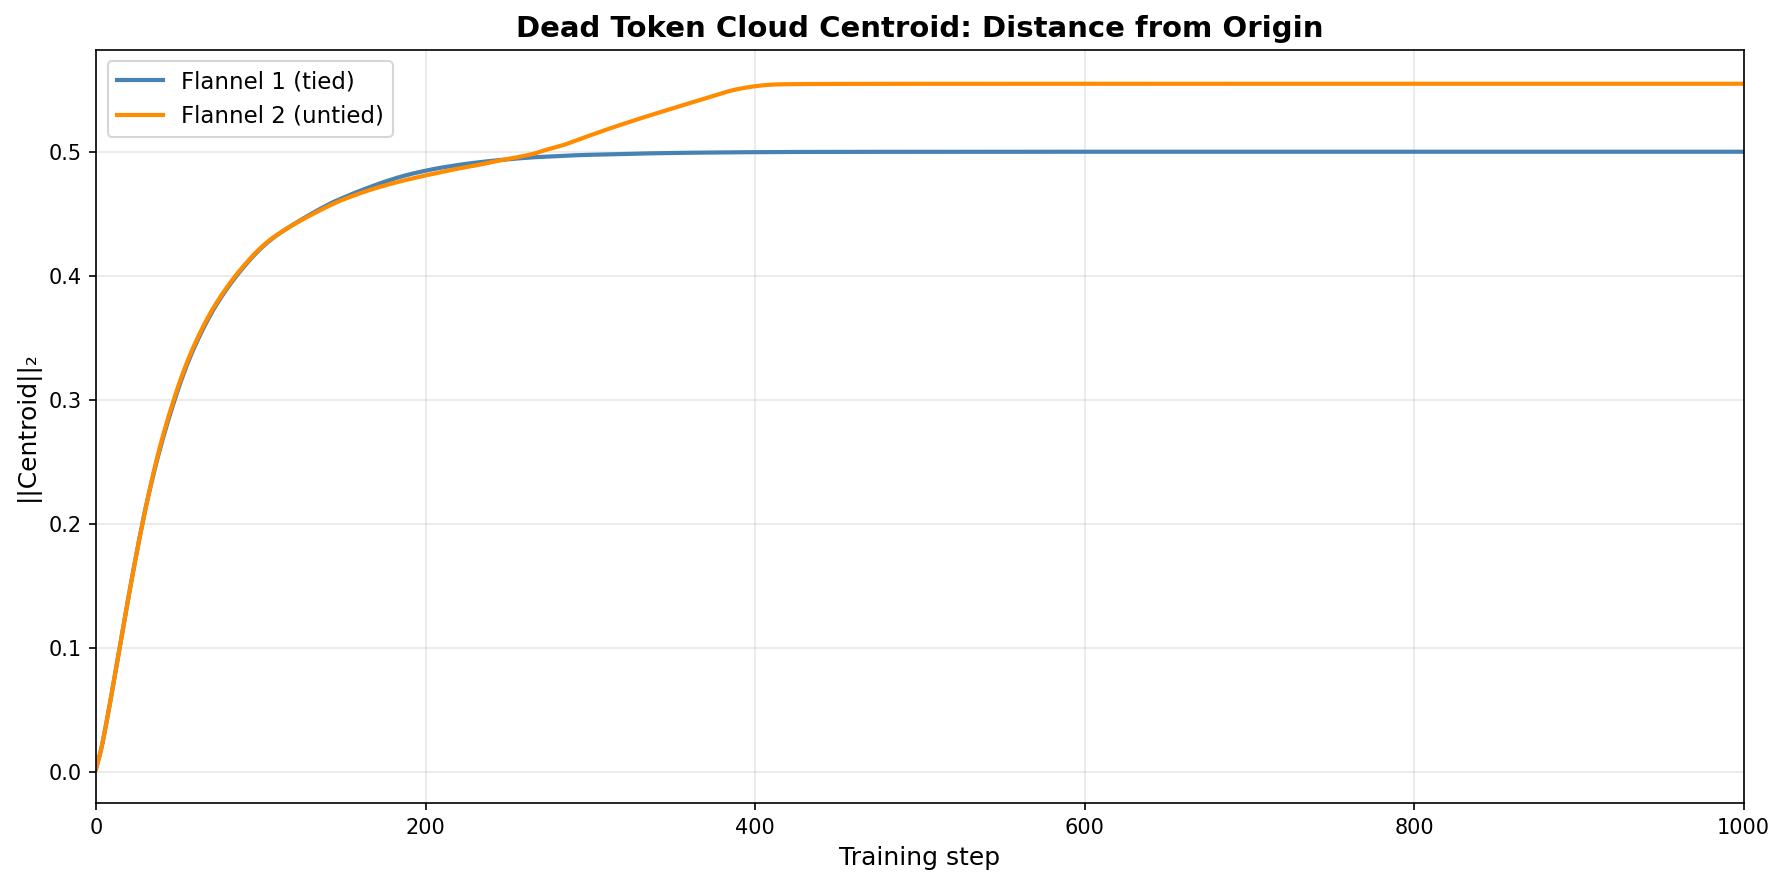

✓ Centroid norm plot complete


In [7]:
print("\nPlotting centroid norm...\n")

fig, ax = plt.subplots(figsize=(12, 6), dpi=PLOT_DPI)

timesteps = np.arange(n_steps)

ax.plot(timesteps, stats_1['centroid_norm'].cpu().numpy(), 
        color=COLOR_F1, linewidth=LINEWIDTH, label='Flannel 1 (tied)')
ax.plot(timesteps, stats_2['centroid_norm'].cpu().numpy(), 
        color=COLOR_F2, linewidth=LINEWIDTH, label='Flannel 2 (untied)')

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('||Centroid||₂', fontsize=12)
ax.set_title('Dead Token Cloud Centroid: Distance from Origin', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
ax.set_xlim(0, n_steps-1)

plt.tight_layout()
plt.show()

print("✓ Centroid norm plot complete")

## Plot: Cloud Radius (from Centroid)


Plotting cloud radius...



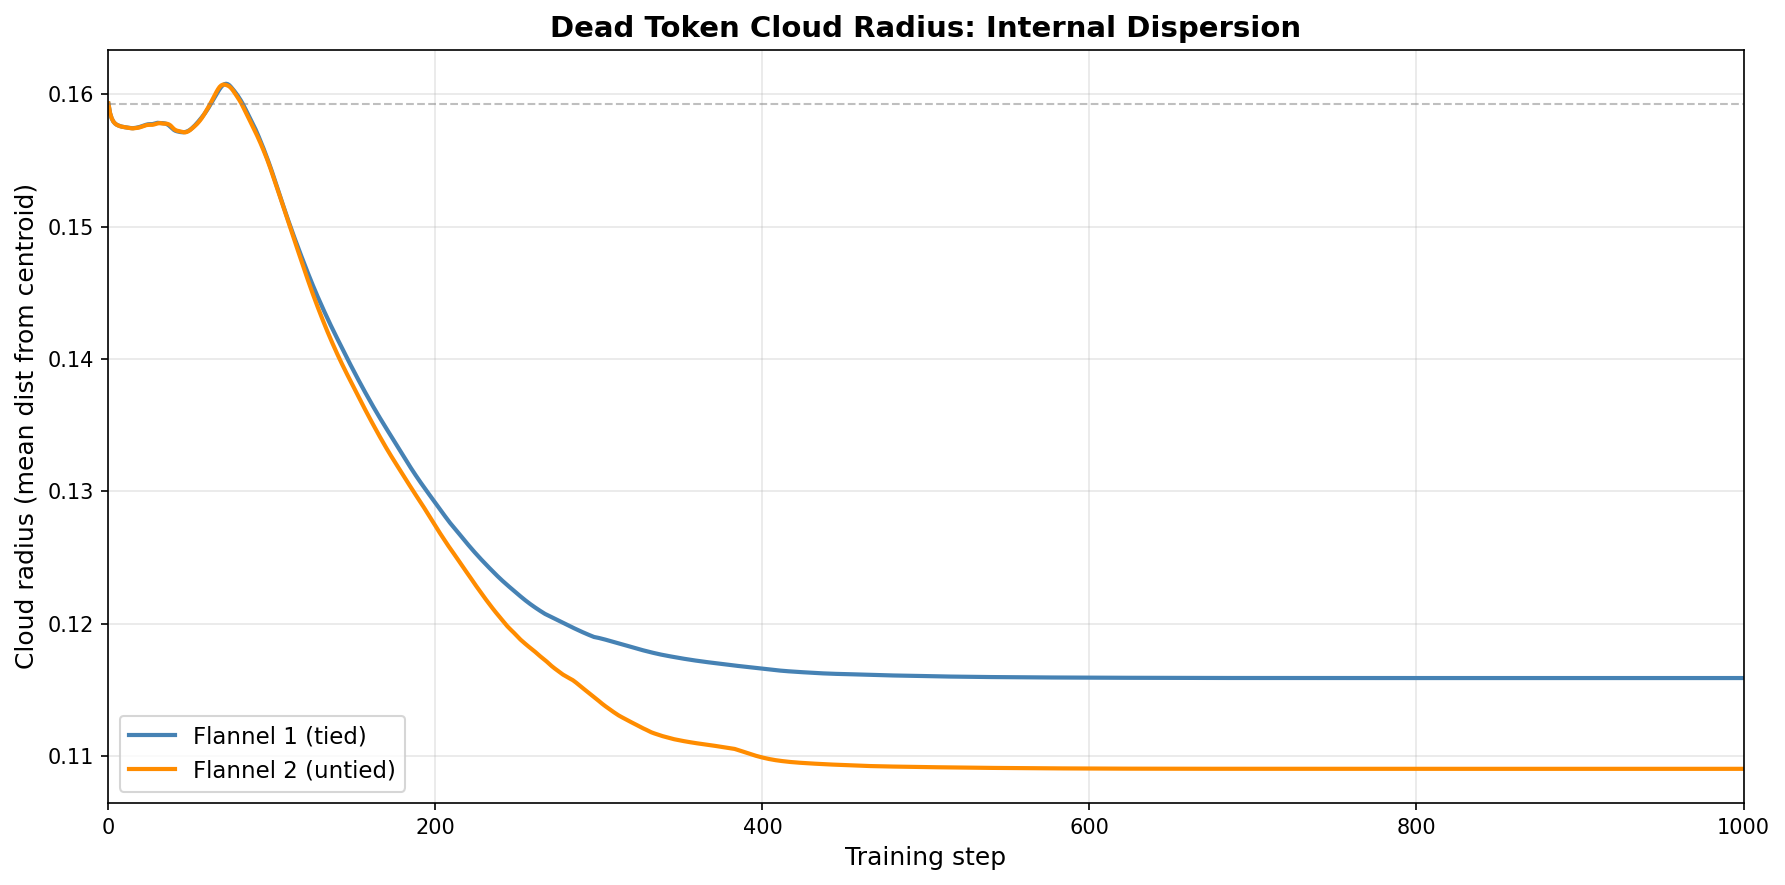

✓ Cloud radius plot complete


In [8]:
print("\nPlotting cloud radius...\n")

fig, ax = plt.subplots(figsize=(12, 6), dpi=PLOT_DPI)

ax.plot(timesteps, stats_1['cloud_radius'].cpu().numpy(), 
        color=COLOR_F1, linewidth=LINEWIDTH, label='Flannel 1 (tied)')
ax.plot(timesteps, stats_2['cloud_radius'].cpu().numpy(), 
        color=COLOR_F2, linewidth=LINEWIDTH, label='Flannel 2 (untied)')

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Cloud radius (mean dist from centroid)', fontsize=12)
ax.set_title('Dead Token Cloud Radius: Internal Dispersion', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
ax.set_xlim(0, n_steps-1)

# Reference line at t=0
init_radius = stats_1['cloud_radius'][0].item()
ax.axhline(init_radius, color='gray', linestyle='--', linewidth=1, alpha=0.5,
           label=f't=0: {init_radius:.6f}')

plt.tight_layout()
plt.show()

print("✓ Cloud radius plot complete")

## Plot: Mean Distance from Origin


Plotting origin radius...



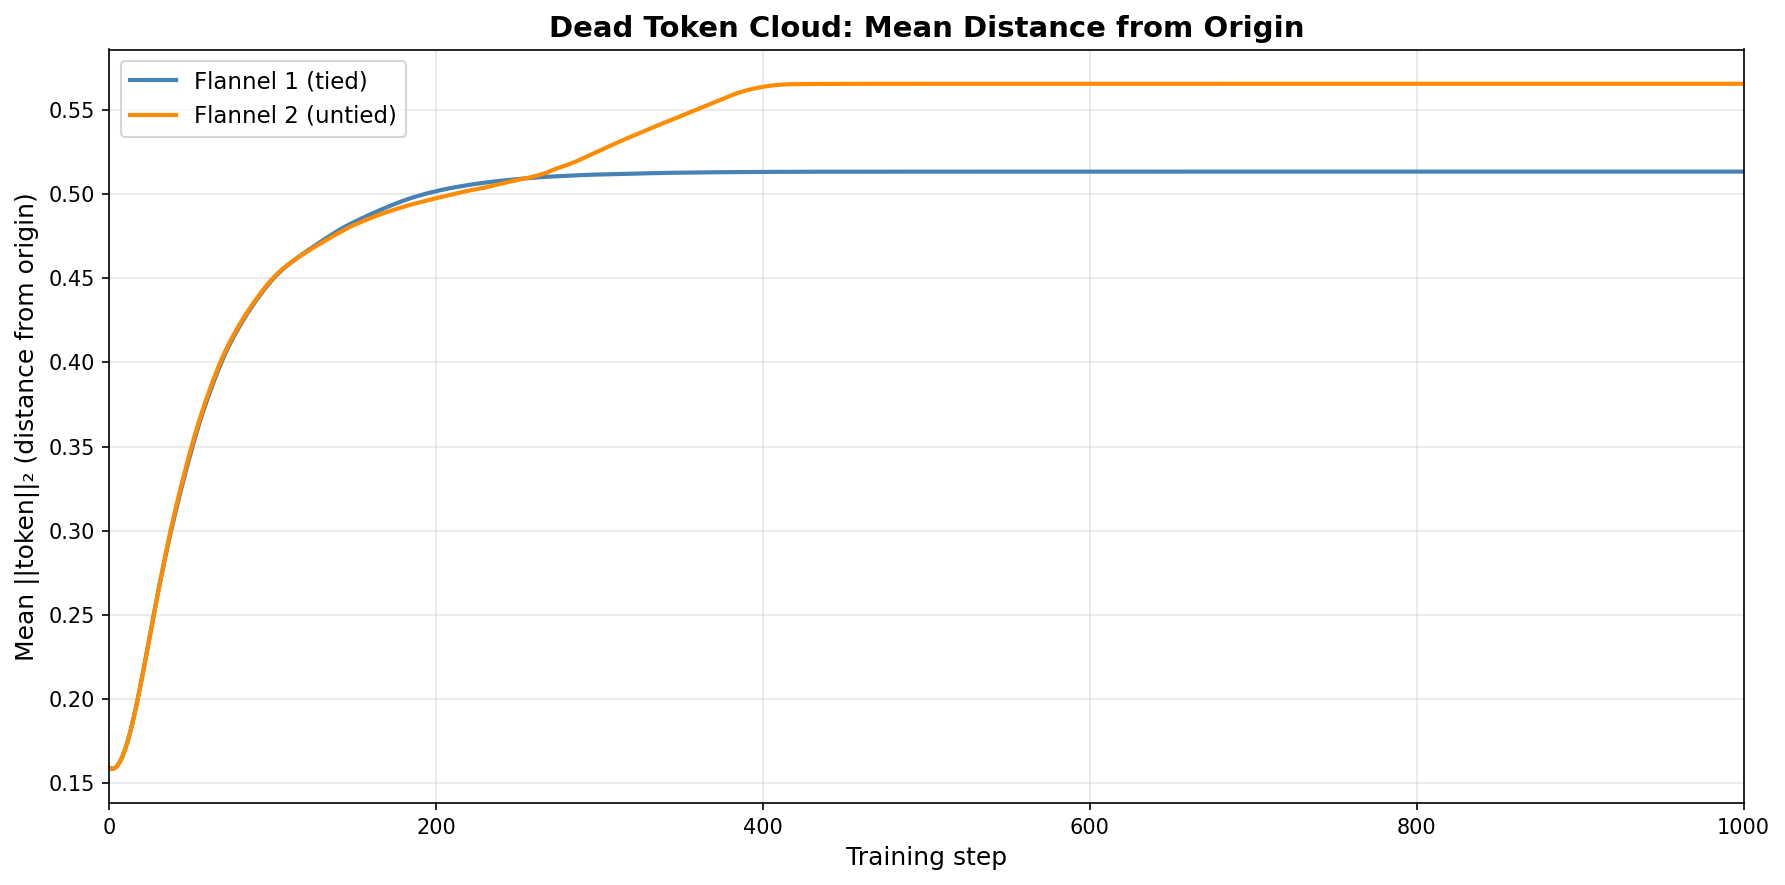

✓ Origin radius plot complete


In [9]:
print("\nPlotting origin radius...\n")

fig, ax = plt.subplots(figsize=(12, 6), dpi=PLOT_DPI)

ax.plot(timesteps, stats_1['origin_radius'].cpu().numpy(), 
        color=COLOR_F1, linewidth=LINEWIDTH, label='Flannel 1 (tied)')
ax.plot(timesteps, stats_2['origin_radius'].cpu().numpy(), 
        color=COLOR_F2, linewidth=LINEWIDTH, label='Flannel 2 (untied)')

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Mean ||token||₂ (distance from origin)', fontsize=12)
ax.set_title('Dead Token Cloud: Mean Distance from Origin', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
ax.set_xlim(0, n_steps-1)

plt.tight_layout()
plt.show()

print("✓ Origin radius plot complete")

## Plot: Standard Deviation Per Dimension


Plotting std per dimension...



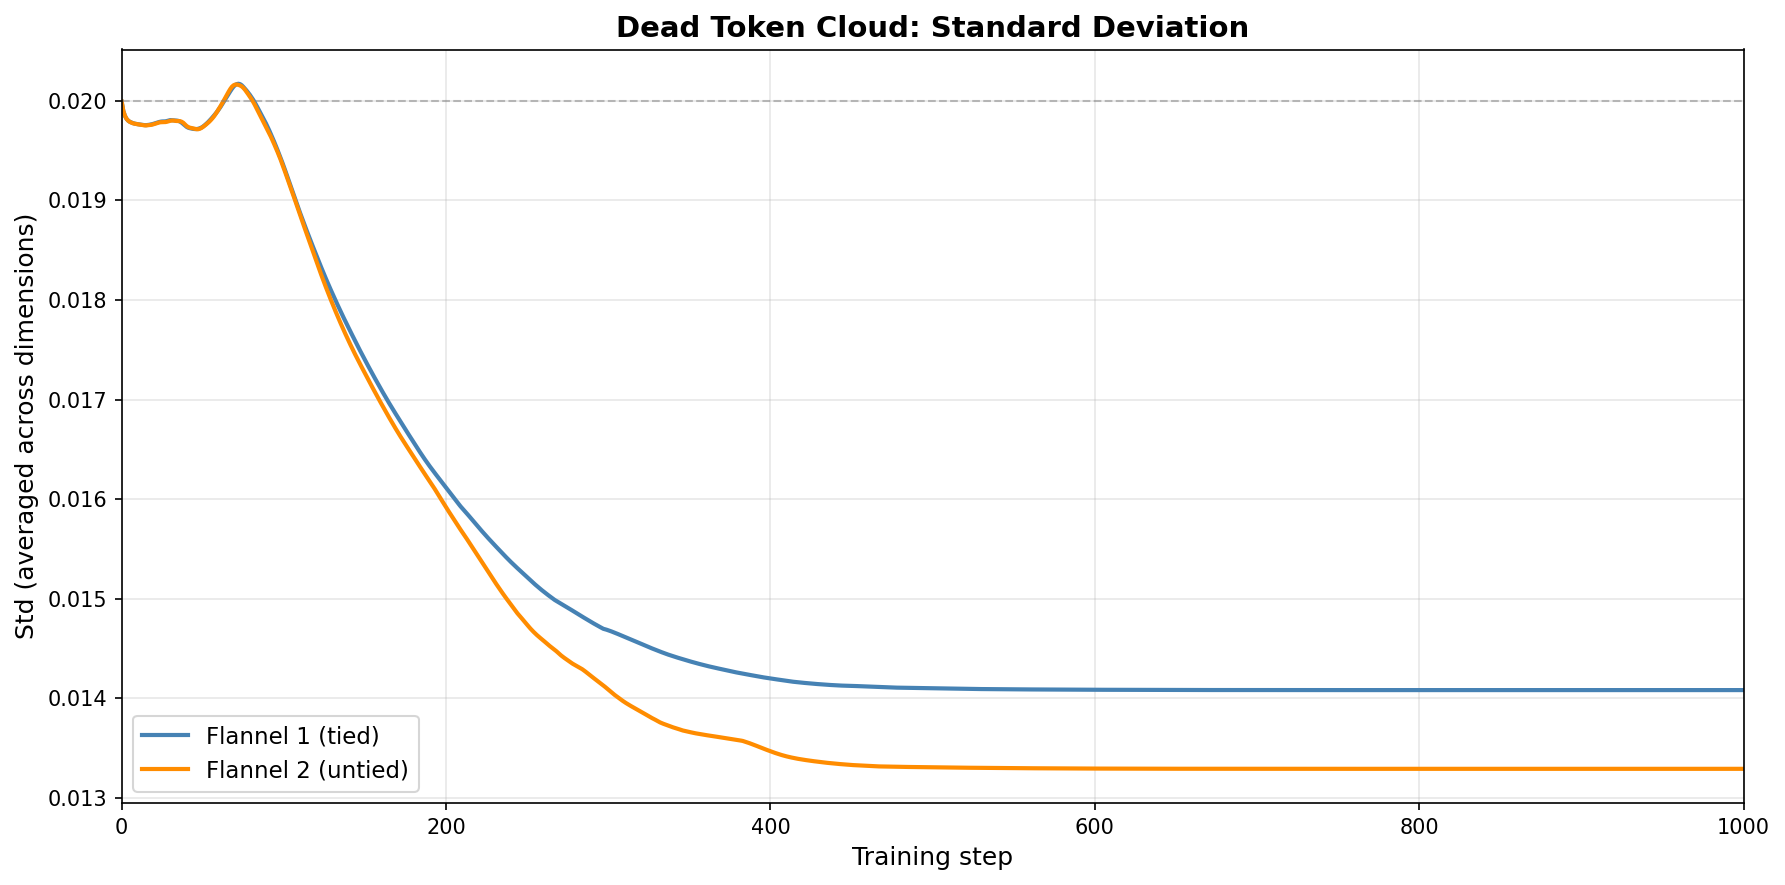

✓ Std plot complete


In [10]:
print("\nPlotting std per dimension...\n")

fig, ax = plt.subplots(figsize=(12, 6), dpi=PLOT_DPI)

ax.plot(timesteps, stats_1['std_per_dim'].cpu().numpy(), 
        color=COLOR_F1, linewidth=LINEWIDTH, label='Flannel 1 (tied)')
ax.plot(timesteps, stats_2['std_per_dim'].cpu().numpy(), 
        color=COLOR_F2, linewidth=LINEWIDTH, label='Flannel 2 (untied)')

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Std (averaged across dimensions)', fontsize=12)
ax.set_title('Dead Token Cloud: Standard Deviation', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
ax.set_xlim(0, n_steps-1)

# Reference line at init (0.02)
ax.axhline(0.02, color='gray', linestyle='--', linewidth=1, alpha=0.5,
           label='Init: σ=0.02')

plt.tight_layout()
plt.show()

print("✓ Std plot complete")

## Combined View: All Metrics


Plotting combined view...



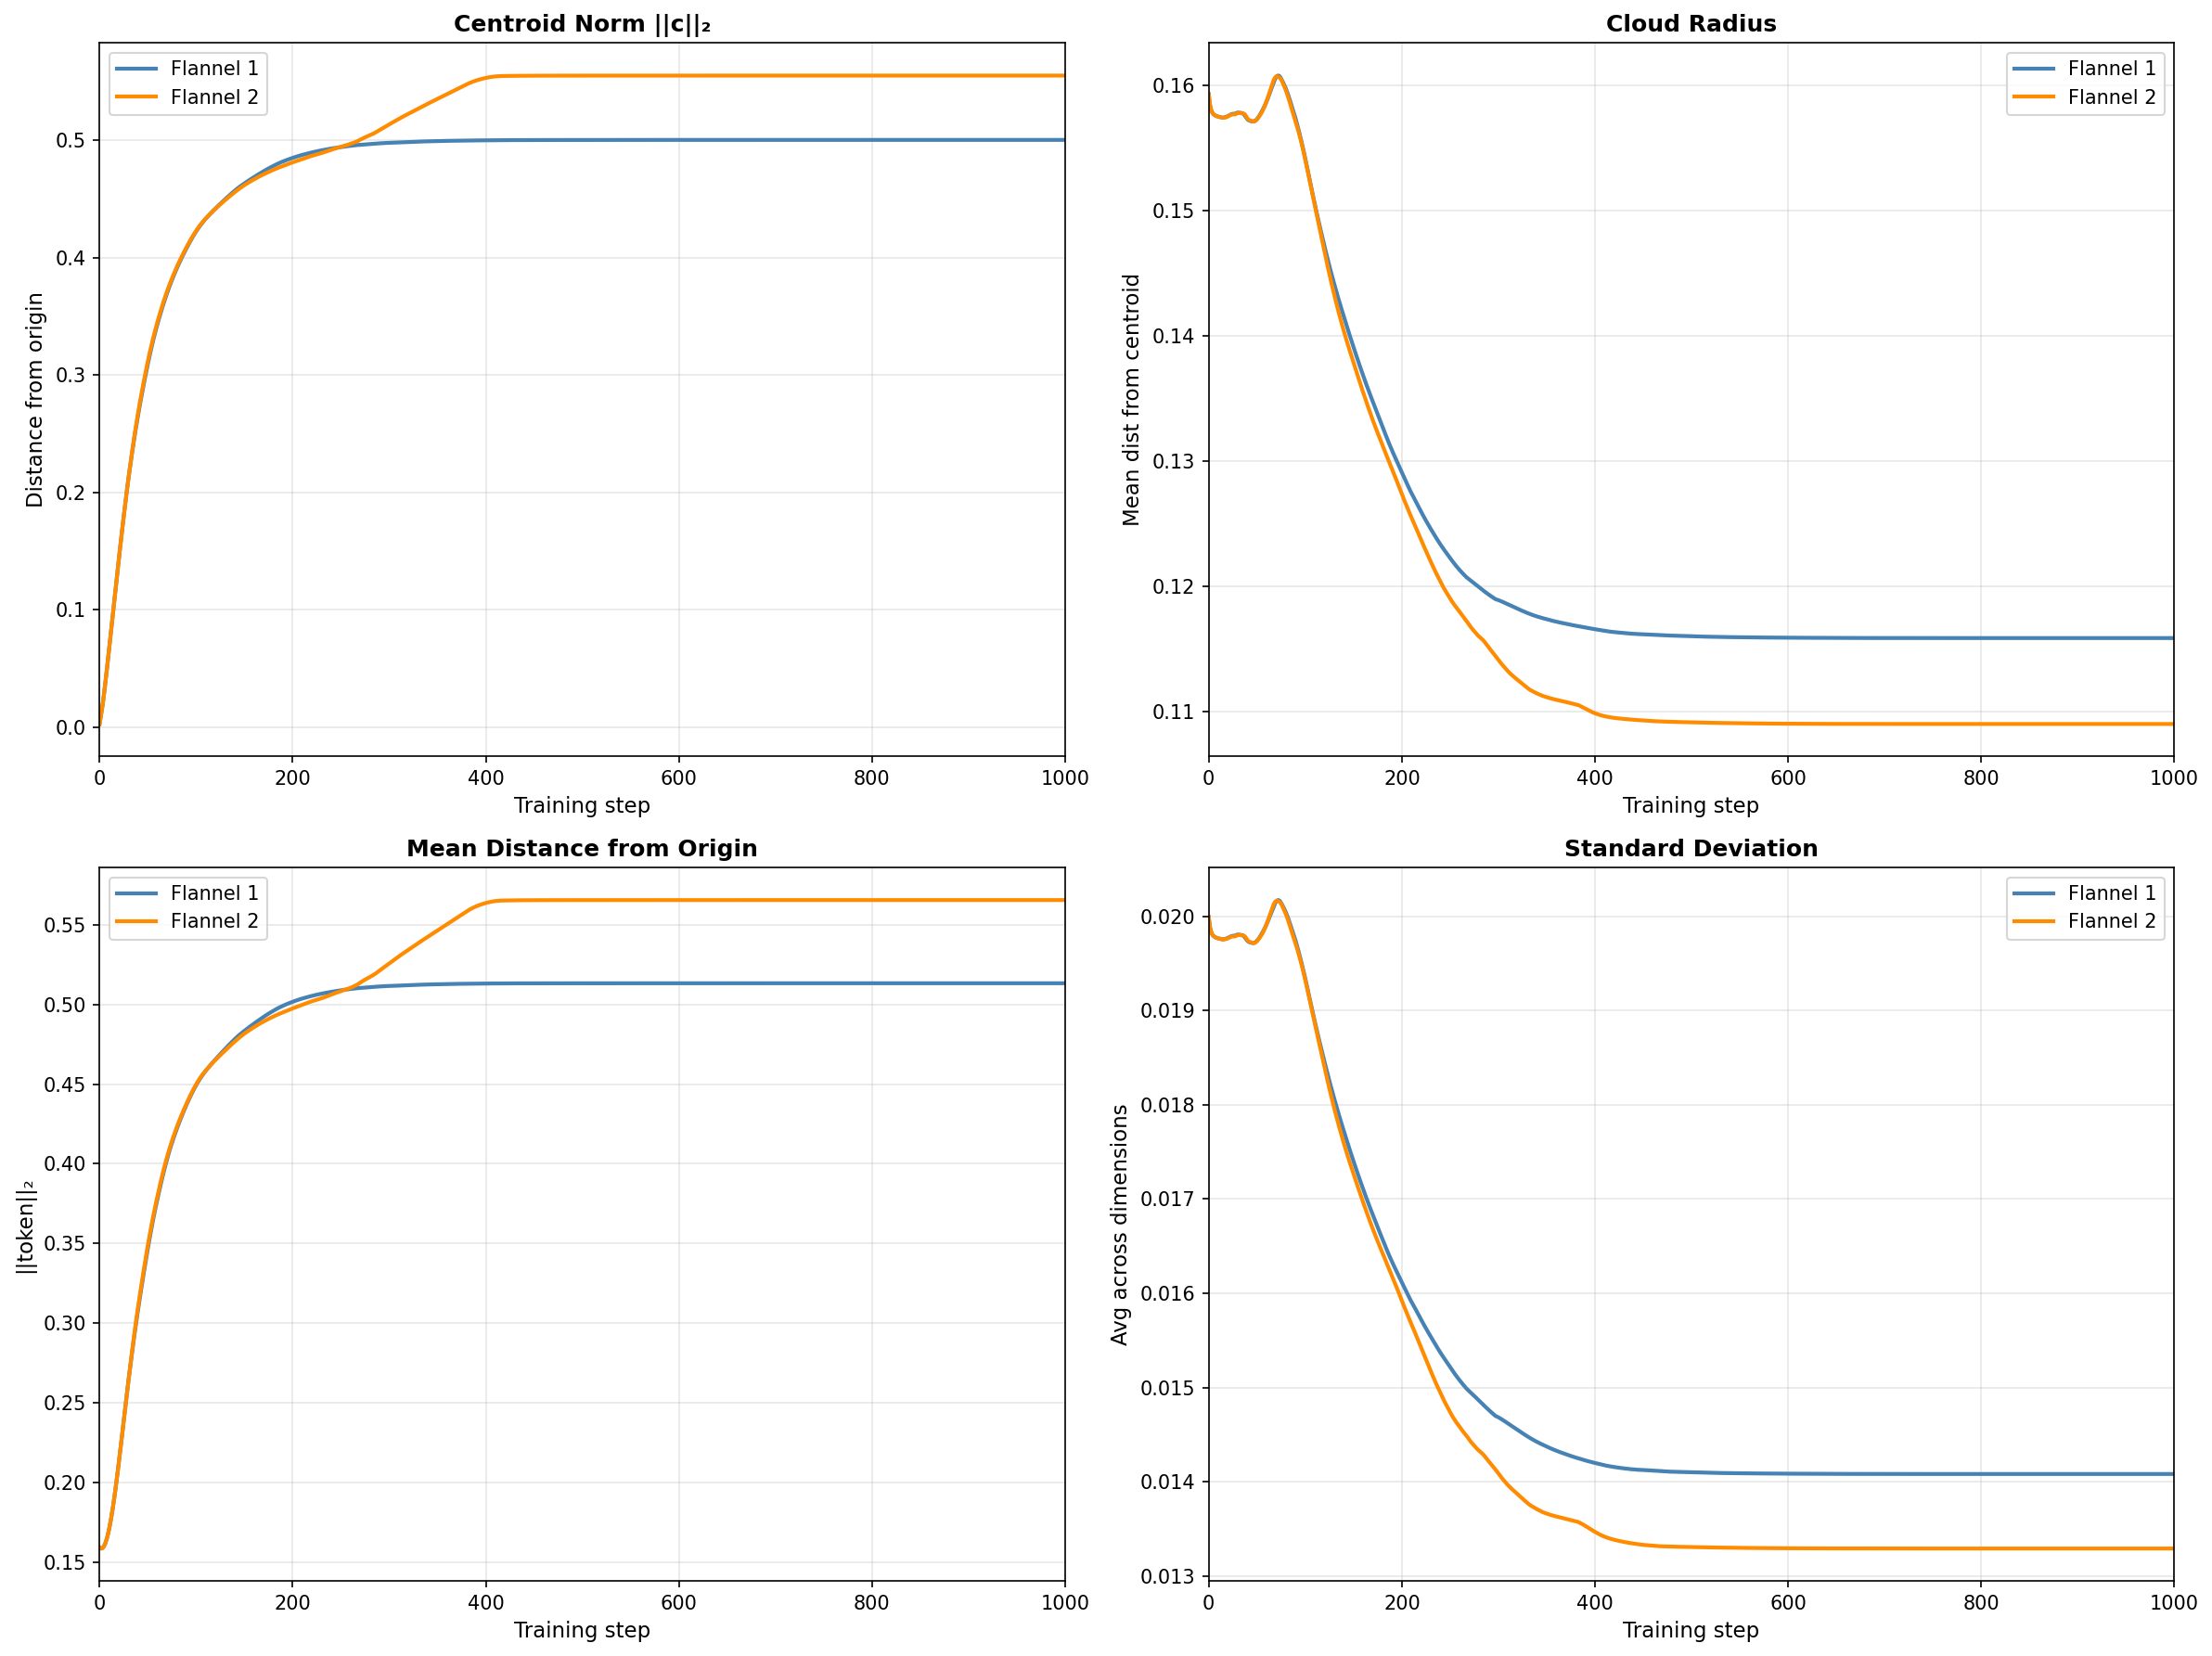

✓ Combined view complete


In [11]:
print("\nPlotting combined view...\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=PLOT_DPI)

metrics = [
    ('centroid_norm', 'Centroid Norm ||c||₂', 'Distance from origin'),
    ('cloud_radius', 'Cloud Radius', 'Mean dist from centroid'),
    ('origin_radius', 'Mean Distance from Origin', '||token||₂'),
    ('std_per_dim', 'Standard Deviation', 'Avg across dimensions')
]

for ax, (key, title, ylabel) in zip(axes.flat, metrics):
    ax.plot(timesteps, stats_1[key].cpu().numpy(), 
            color=COLOR_F1, linewidth=LINEWIDTH, label='Flannel 1')
    ax.plot(timesteps, stats_2[key].cpu().numpy(), 
            color=COLOR_F2, linewidth=LINEWIDTH, label='Flannel 2')
    
    ax.set_xlabel('Training step', fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    ax.set_xlim(0, n_steps-1)

plt.tight_layout()
plt.show()

print("✓ Combined view complete")

## Difference Between Experiments


Computing differences between experiments...



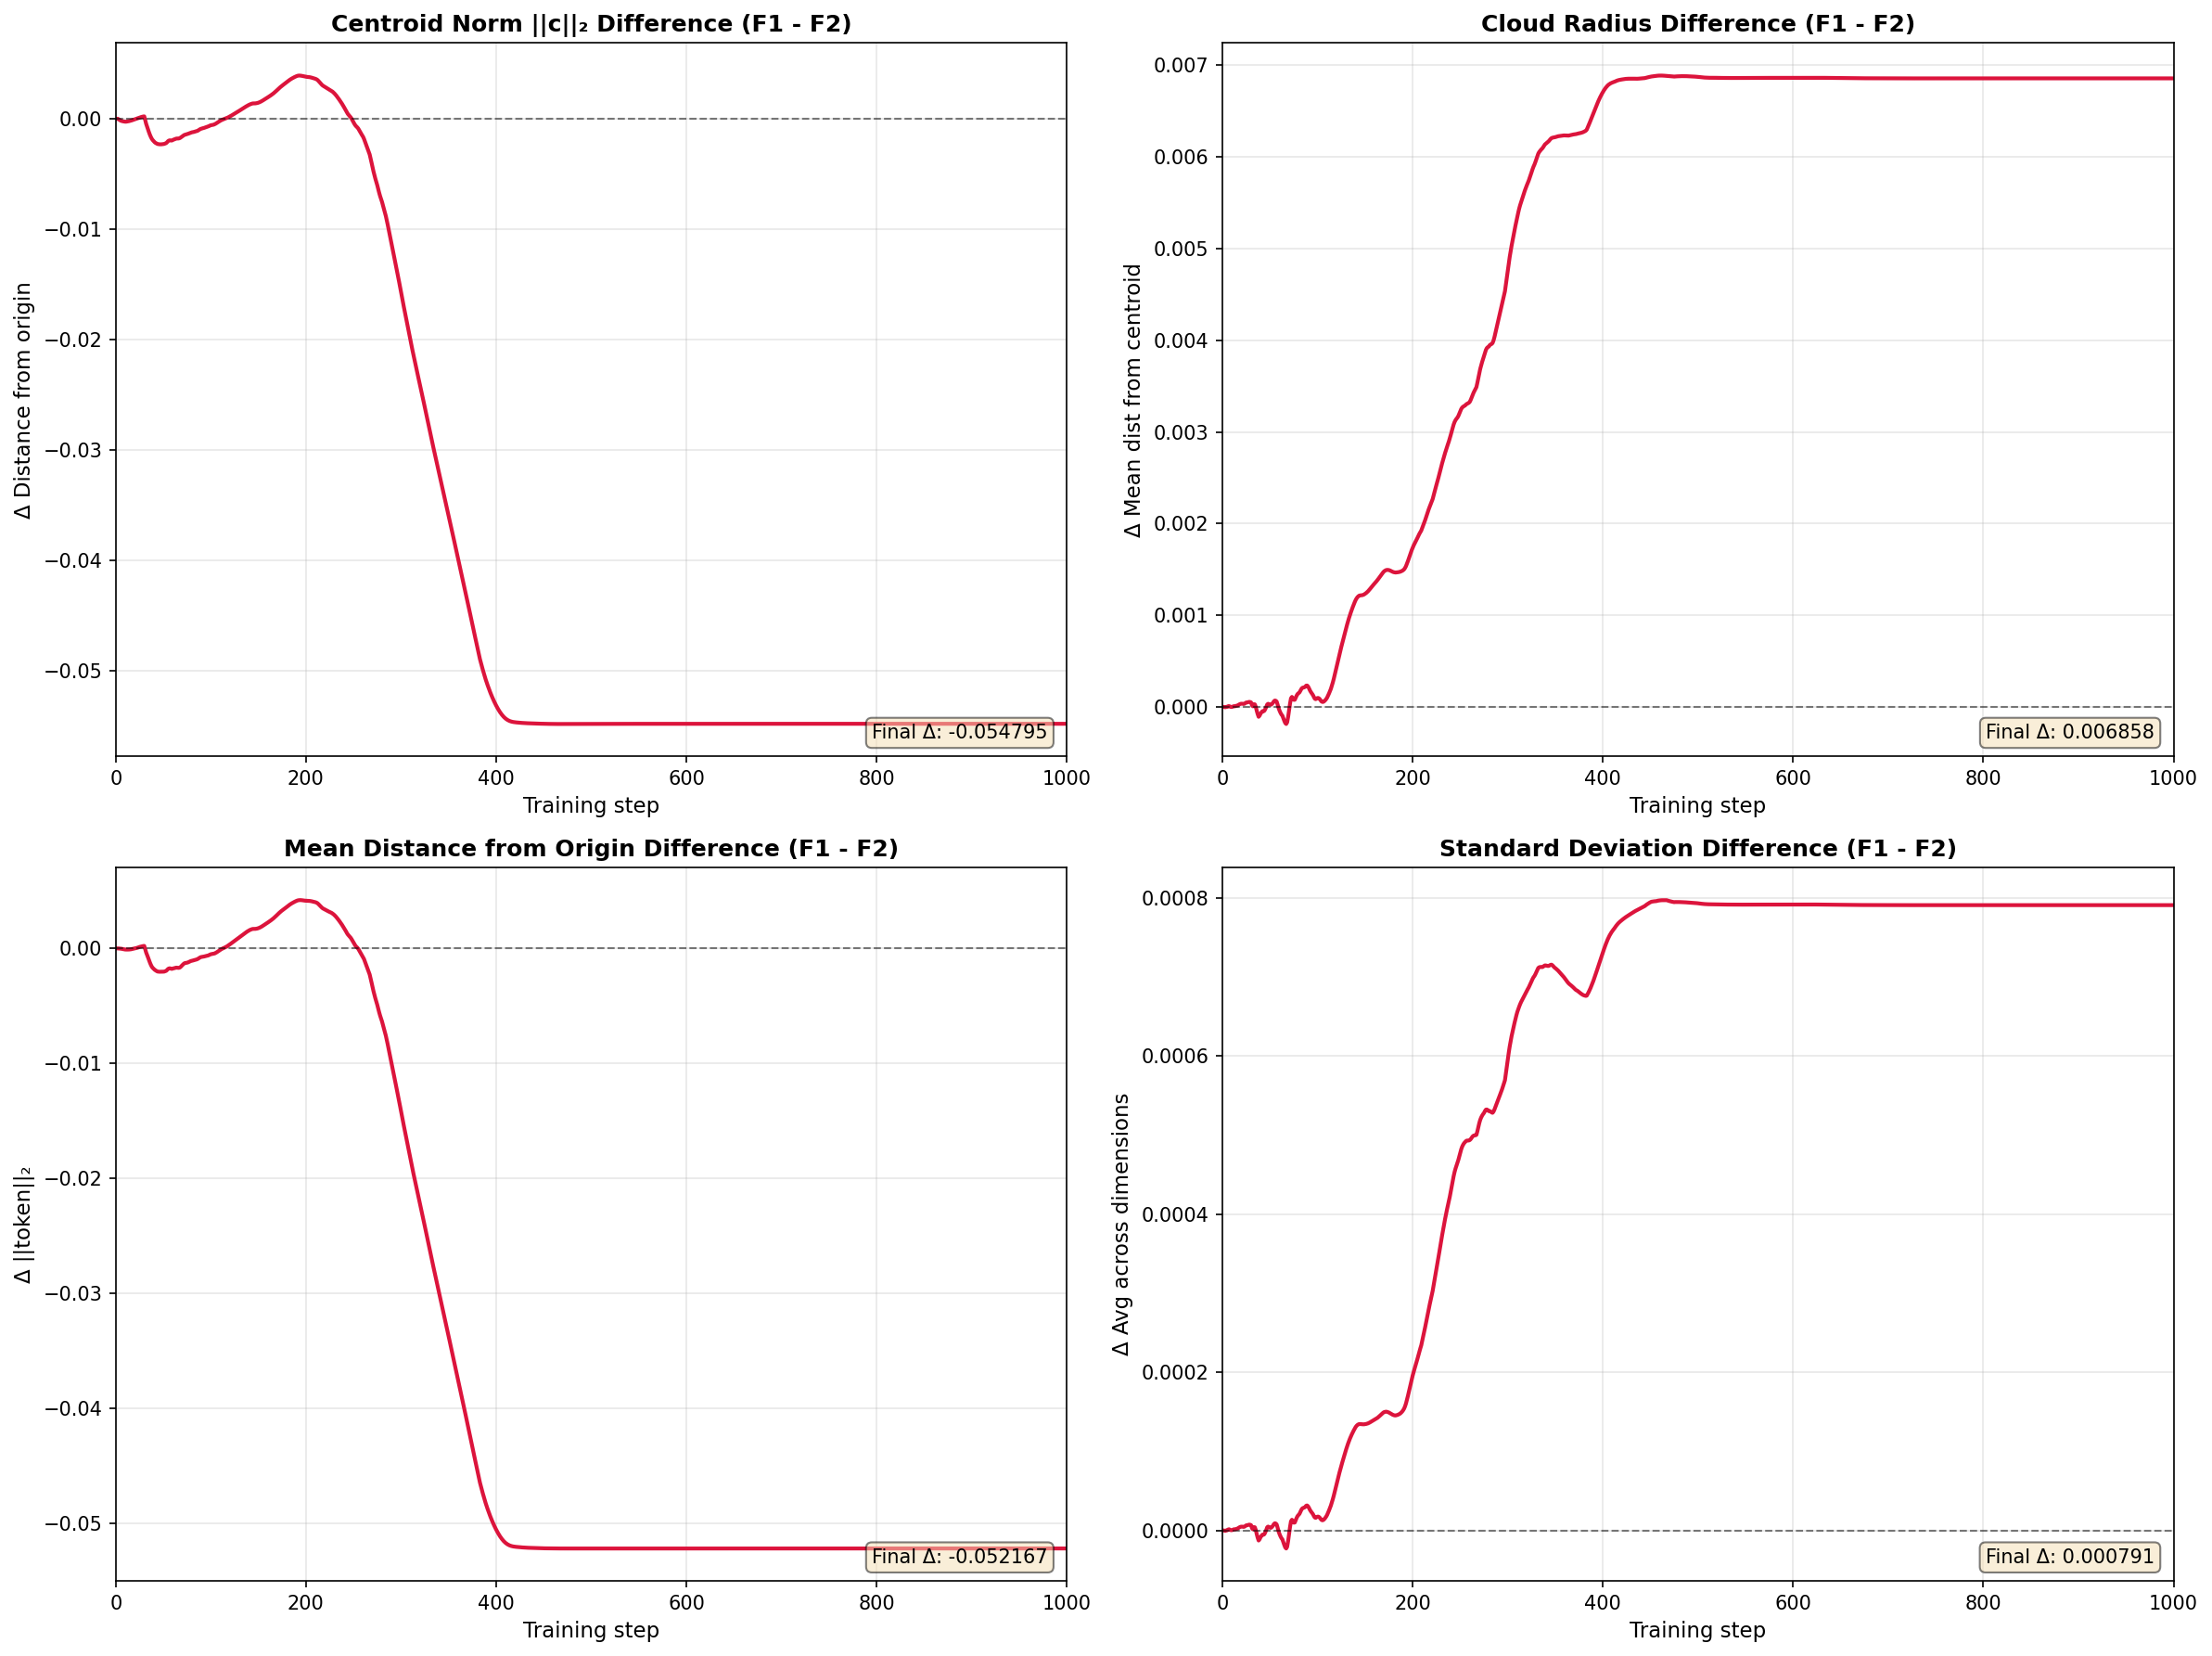

✓ Difference plots complete


In [12]:
print("\nComputing differences between experiments...\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=PLOT_DPI)

for ax, (key, title, ylabel) in zip(axes.flat, metrics):
    diff = (stats_1[key] - stats_2[key]).cpu().numpy()
    
    ax.plot(timesteps, diff, color='crimson', linewidth=LINEWIDTH)
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_xlabel('Training step', fontsize=11)
    ax.set_ylabel(f'Δ {ylabel}', fontsize=11)
    ax.set_title(f'{title} Difference (F1 - F2)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, n_steps-1)
    
    # Annotation with final difference
    final_diff = diff[-1]
    ax.text(0.98, 0.02, f'Final Δ: {final_diff:.6f}',
            transform=ax.transAxes, fontsize=10, 
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("✓ Difference plots complete")

## Summary

In [13]:
print("\n" + "="*80)
print("DEAD TOKEN CLOUD GEOMETRY SUMMARY")
print("="*80 + "\n")

print(f"Dead tokens: {n_dead}")
print(f"Hidden dimensions: {hidden_dim}")
print(f"Training steps: {n_steps}")
print()

print(f"Initial conditions (t=0):")
print(f"  Initialization: N(0, 0.02)")
print(f"  Centroid norm: {stats_1['centroid_norm'][0].item():.6f}")
print(f"  Cloud radius: {stats_1['cloud_radius'][0].item():.6f}")
print(f"  Std per dim: {stats_1['std_per_dim'][0].item():.6f}")
print()

print(f"Final state (t={n_steps-1}):")
print()
print(f"  Flannel 1 (tied weights):")
print(f"    Centroid norm: {stats_1['centroid_norm'][-1].item():.6f}")
print(f"    Cloud radius: {stats_1['cloud_radius'][-1].item():.6f}")
print(f"    Origin radius: {stats_1['origin_radius'][-1].item():.6f}")
print(f"    Std per dim: {stats_1['std_per_dim'][-1].item():.6f}")
print()
print(f"  Flannel 2 (untied weights):")
print(f"    Centroid norm: {stats_2['centroid_norm'][-1].item():.6f}")
print(f"    Cloud radius: {stats_2['cloud_radius'][-1].item():.6f}")
print(f"    Origin radius: {stats_2['origin_radius'][-1].item():.6f}")
print(f"    Std per dim: {stats_2['std_per_dim'][-1].item():.6f}")
print()

print(f"Differences (Flannel 1 - Flannel 2):")
for key, name in [('centroid_norm', 'Centroid norm'), 
                   ('cloud_radius', 'Cloud radius'),
                   ('origin_radius', 'Origin radius'),
                   ('std_per_dim', 'Std per dim')]:
    diff_final = (stats_1[key][-1] - stats_2[key][-1]).item()
    pct_diff = 100 * diff_final / stats_1[key][-1].item()
    print(f"  {name}: {diff_final:+.6f} ({pct_diff:+.2f}%)")
print()

# Interpretation
print(f"Interpretation:")
print()

# Check if bulk geometry is similar
centroid_diff_pct = abs(100 * (stats_1['centroid_norm'][-1] - stats_2['centroid_norm'][-1]).item() / stats_1['centroid_norm'][-1].item())
radius_diff_pct = abs(100 * (stats_1['cloud_radius'][-1] - stats_2['cloud_radius'][-1]).item() / stats_1['cloud_radius'][-1].item())
std_diff_pct = abs(100 * (stats_1['std_per_dim'][-1] - stats_2['std_per_dim'][-1]).item() / stats_1['std_per_dim'][-1].item())

if centroid_diff_pct < 5 and radius_diff_pct < 5 and std_diff_pct < 5:
    print(f"  ✓ SIMILAR BULK GEOMETRY (<5% difference in all metrics)")
    print(f"  → Both clouds have same center, same size, same dispersion")
    print(f"  → Divergence (~0.3 per token) is likely ANGULAR/ROTATIONAL")
    print(f"  → Tokens at similar radii but different angular positions")
    print(f"  → Like two rotated copies of the same spherical shell")
elif centroid_diff_pct < 10 and radius_diff_pct < 10 and std_diff_pct < 10:
    print(f"  ~ MOSTLY SIMILAR GEOMETRY (<10% difference)")
    print(f"  → Clouds have similar overall structure")
    print(f"  → Small differences in center/size/dispersion")
else:
    print(f"  ✗ DIFFERENT BULK GEOMETRY (>10% difference)")
    print(f"  → Clouds have fundamentally different shapes or positions")
    print(f"  → Divergence reflects structural differences, not just rotation")

print("\n" + "="*80)


DEAD TOKEN CLOUD GEOMETRY SUMMARY

Dead tokens: 3699
Hidden dimensions: 64
Training steps: 1001

Initial conditions (t=0):
  Initialization: N(0, 0.02)
  Centroid norm: 0.002689
  Cloud radius: 0.159301
  Std per dim: 0.019992

Final state (t=1000):

  Flannel 1 (tied weights):
    Centroid norm: 0.500136
    Cloud radius: 0.115900
    Origin radius: 0.513296
    Std per dim: 0.014081

  Flannel 2 (untied weights):
    Centroid norm: 0.554931
    Cloud radius: 0.109042
    Origin radius: 0.565463
    Std per dim: 0.013290

Differences (Flannel 1 - Flannel 2):
  Centroid norm: -0.054795 (-10.96%)
  Cloud radius: +0.006858 (+5.92%)
  Origin radius: -0.052167 (-10.16%)
  Std per dim: +0.000791 (+5.62%)

Interpretation:

  ✗ DIFFERENT BULK GEOMETRY (>10% difference)
  → Clouds have fundamentally different shapes or positions
  → Divergence reflects structural differences, not just rotation

